# 🥙 LSTM on Recipe Data

In this notebook, we'll walk through the steps required to train your own LSTM on the recipes dataset

In [ ]:
#%load_ext autoreload
#%autoreload 2

import numpy as np
import json
import re
import string

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses

## 0. Parameters <a name="parameters"></a>

In [ ]:
VOCAB_SIZE = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
N_UNITS = 128
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 25

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Load the data <a name="load"></a>

In [ ]:
# Load the full dataset
with open("/content/drive/MyDrive/full_format_recipes.json") as json_data:
    recipe_data = json.load(json_data)

In [ ]:
# Filter the dataset
filtered_data = [
    "Recipe for " + x["title"] + " | " + " ".join(x["directions"])
    for x in recipe_data
    if "title" in x
    and x["title"] is not None
    and "directions" in x
    and x["directions"] is not None
]

In [ ]:
# Count the recipes
n_recipes = len(filtered_data)
print(f"{n_recipes} recipes loaded")

20111 recipes loaded


In [ ]:
example = filtered_data[9]
print(example)

Recipe for Ham Persillade with Mustard Potato Salad and Mashed Peas  | Chop enough parsley leaves to measure 1 tablespoon; reserve. Chop remaining leaves and stems and simmer with broth and garlic in a small saucepan, covered, 5 minutes. Meanwhile, sprinkle gelatin over water in a medium bowl and let soften 1 minute. Strain broth through a fine-mesh sieve into bowl with gelatin and stir to dissolve. Season with salt and pepper. Set bowl in an ice bath and cool to room temperature, stirring. Toss ham with reserved parsley and divide among jars. Pour gelatin on top and chill until set, at least 1 hour. Whisk together mayonnaise, mustard, vinegar, 1/4 teaspoon salt, and 1/4 teaspoon pepper in a large bowl. Stir in celery, cornichons, and potatoes. Pulse peas with marjoram, oil, 1/2 teaspoon pepper, and 1/4 teaspoon salt in a food processor to a coarse mash. Layer peas, then potato salad, over ham.


## 2. Tokenise the data

In [ ]:
# Pad the punctuation, to treat them as separate 'words'
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}])", r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s


text_data = [pad_punctuation(x) for x in filtered_data]

In [ ]:
# Display an example of a recipe
example_data = text_data[9]
example_data

'Recipe for Ham Persillade with Mustard Potato Salad and Mashed Peas | Chop enough parsley leaves to measure 1 tablespoon ; reserve . Chop remaining leaves and stems and simmer with broth and garlic in a small saucepan , covered , 5 minutes . Meanwhile , sprinkle gelatin over water in a medium bowl and let soften 1 minute . Strain broth through a fine - mesh sieve into bowl with gelatin and stir to dissolve . Season with salt and pepper . Set bowl in an ice bath and cool to room temperature , stirring . Toss ham with reserved parsley and divide among jars . Pour gelatin on top and chill until set , at least 1 hour . Whisk together mayonnaise , mustard , vinegar , 1 / 4 teaspoon salt , and 1 / 4 teaspoon pepper in a large bowl . Stir in celery , cornichons , and potatoes . Pulse peas with marjoram , oil , 1 / 2 teaspoon pepper , and 1 / 4 teaspoon salt in a food processor to a coarse mash . Layer peas , then potato salad , over ham . '

In [ ]:
# Convert to a Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

In [ ]:
# Create a vectorisation layer
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1,
)

In [ ]:
# Adapt the layer to the training set
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [ ]:
# Display some token:word mappings
for i, word in enumerate(vocab[:10]):
    print(f"{i}: {word}")

0: 
1: [UNK]
2: .
3: ,
4: and
5: to
6: in
7: the
8: with
9: a


In [ ]:
# Display the same example converted to ints
example_tokenised = vectorize_layer(example_data)
print(example_tokenised.numpy())

[  26   16  557    1    8  298  335  189    4 1054  494   27  332  228
  235  262    5  594   11  133   22  311    2  332   45  262    4  671
    4   70    8  171    4   81    6    9   65   80    3  121    3   59
   12    2  299    3   88  650   20   39    6    9   29   21    4   67
  529   11  164    2  320  171  102    9  374   13  643  306   25   21
    8  650    4   42    5  931    2   63    8   24    4   33    2  114
   21    6  178  181 1245    4   60    5  140  112    3   48    2  117
  557    8  285  235    4  200  292  980    2  107  650   28   72    4
  108   10  114    3   57  204   11  172    2   73  110  482    3  298
    3  190    3   11   23   32  142   24    3    4   11   23   32  142
   33    6    9   30   21    2   42    6  353    3 3224    3    4  150
    2  437  494    8 1281    3   37    3   11   23   15  142   33    3
    4   11   23   32  142   24    6    9  291  188    5    9  412  572
    2  230  494    3   46  335  189    3   20  557    2    0    0    0
    0 

## 3. Create the Training Set

In [ ]:
# Create the training set of recipes and the same text shifted by one word
def prepare_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


train_ds = text_ds.map(prepare_inputs)

## 4. Build the LSTM <a name="build"></a>

In [ ]:
inputs = layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, None, 128)         117248    
                                                                 
 dense (Dense)               (None, None, 10000)       1290000   
                                                                 
Total params: 2407248 (9.18 MB)
Trainable params: 2407248 (9.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
if LOAD_MODEL:
    # model.load_weights('./models/model')
    lstm = models.load_model("./models/lstm", compile=False)

## 5. Train the LSTM <a name="train"></a>

In [ ]:
loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile("adam", loss_fn)

In [ ]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }  # <1>

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]  # <3>
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:  # <4>
            x = np.array([start_tokens])
            y = self.model.predict(x, verbose=0)  # <5>
            sample_token, probs = self.sample_from(y[0][-1], temperature)  # <6>
            info.append({"prompt": start_prompt, "word_probs": probs})
            start_tokens.append(sample_token)  # <7>
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("recipe for", max_tokens=100, temperature=1.0)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [ ]:
history = lstm.fit(
    train_ds,
    epochs=10, #EPOCHS,
    callbacks=[model_checkpoint_callback, text_generator],
)

Epoch 1/10
628/629 [============================>.] - ETA: 0s - loss: 3.8974
generated text:
recipe for spicy - slices with whose to cracked com , beans with the pieces in a blender rotating colander over and apple 20 oil , stirring more , porcini . whisk in small bowl over a measure 20 minutes . transfer burgers and roll leaves . add toasted thinly corn for for - simmer oven , onion ; melt juice with medium shallow electric quart bowl . 12 - low and 2 oil . return bowl and sauté 10 the mint , heat in sour to small fat in bowl , stirring , each side completely , sea remove

629/629 [==============================] - 42s 67ms/step - loss: 3.8963
Epoch 2/10
629/629 [==============================] - ETA: 0s - loss: 2.8837
generated text:
recipe for strips stuffing | thinly 13x10 parchment rack and vinegar potatoes with oven . in a bowl preheat / skillet over moderate heat non - medium bowl and simmer in a medium slow stream , carrot and salt and pepper and transfer to a plate . crack the

In [ ]:
# Save the final model
lstm.save("./models/lstm")

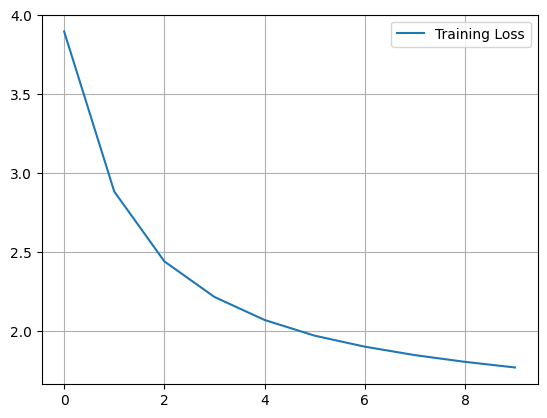

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="Training Loss")
#plt.plot(history.history["val_loss"], label="Validation Loss")
plt.grid()
plt.legend()
plt.show()

## 6. Generate text using the LSTM

In [ ]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        print(f"\nPROMPT: {i['prompt']}")
        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [ ]:
info = text_generator.generate(
    "recipe for roasted vegetables | chop 1 /", max_tokens=10, temperature=1.0
)


generated text:
recipe for roasted vegetables | chop 1 / 2 cup



In [ ]:
print_probs(info, vocab)


PROMPT: recipe for roasted vegetables | chop 1 /
2:   	43.94%
4:   	38.57%
3:   	9.12%
8:   	3.7%
1:   	1.19%
--------


PROMPT: recipe for roasted vegetables | chop 1 / 2
cup:   	58.6%
teaspoon:   	9.6%
tsp:   	4.42%
cups:   	2.55%
of:   	2.42%
--------



In [ ]:
info = text_generator.generate(
    "recipe for roasted vegetables | chop 1 /", max_tokens=10, temperature=0.2
)


generated text:
recipe for roasted vegetables | chop 1 / 4 cup



In [ ]:
print_probs(info, vocab)


PROMPT: recipe for roasted vegetables | chop 1 /
2:   	65.7%
4:   	34.27%
3:   	0.03%
8:   	0.0%
1:   	0.0%
--------


PROMPT: recipe for roasted vegetables | chop 1 / 4
cup:   	100.0%
teaspoon:   	0.0%
of:   	0.0%
tsp:   	0.0%
cups:   	0.0%
--------



In [ ]:
info = text_generator.generate(
    "recipe for chocolate ice cream |", max_tokens=7, temperature=1.0
)
print_probs(info, vocab)


generated text:
recipe for chocolate ice cream | whisk


PROMPT: recipe for chocolate ice cream |
in:   	14.26%
preheat:   	13.7%
combine:   	13.42%
bring:   	4.97%
whisk:   	4.91%
--------



In [ ]:
info = text_generator.generate(
    "recipe for chocolate ice cream |", max_tokens=7, temperature=0.2
)
print_probs(info, vocab)


generated text:
recipe for chocolate ice cream | preheat


PROMPT: recipe for chocolate ice cream |
in:   	38.87%
preheat:   	31.79%
combine:   	28.71%
bring:   	0.2%
whisk:   	0.19%
--------

